# Mott-Schottky model for calculating the space charge potential

**Running the code in this notebook (under Mott-Schottky conditions for the 6 defined temperatures) takes approximately 3 minutes (iMac with 4 Ghz i7 processor).**

Analysis of grain boundary effects on ionic conductivity typically considers the space-charge potential as a characteristic parameter. However $r_{GB}$ can be obtained directly from experimental impedance spectroscopy, whereas the space charge potential cannot and is therefore approximated using the Mott-Schottky model. 

$$ r_{GB} = \frac{\rho_{i,x}}{\rho_{i,\infty}} = \frac{\mathrm{exp}(z\Phi_0 / k_BT)}{2z \Phi_0 / k_BT } $$

The conventional Mott-Schottky analysis assumes that the grain boundart region is negligably thin and that oxygen vacancies are fully depleted in the space-charge region. This gives an analytical description of the space-charge behaviour which can be completely characterised from the space charge potential.

The function to calculate the Mott-Schottky aprroximation for the space charge potential takes one argument, and that is the charge of the mobile defect.
```
c_o.solve_MS_approx_for_phi( valence[0] )
```

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.set_up_calculation import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'periodic'
site_charges = False
systems = 'mott-schottky'
core_models = False
site_models = 'site_explicit'

In [3]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.0e-8
grid_x_max = +2.0e-8
bulk_x_min = -2.0e-8
bulk_x_max = -1.0e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]

In [4]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]
initial_guess = [ [ 0.2, 0.2 ] ]
mobilities = [ 1.0, 1.0 ]

In [5]:
data = '../input_data/example_data_2_one_seg_energies.txt'

In [6]:
space_charge_potential_list = []
MS_space_charge_potential_list =[]

limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )
        
        space_charge_potential_list.append(max(c_o.phi))
        MS_space_charge_potential_list.append(c_o.ms_phi)

--- 184.58980011940002 seconds ---


The space-charge potential calculated using the Mott-Schottky model can be compared to the space-charge potential calculated using the Poisson-Boltzmann solver as demonstrated below.

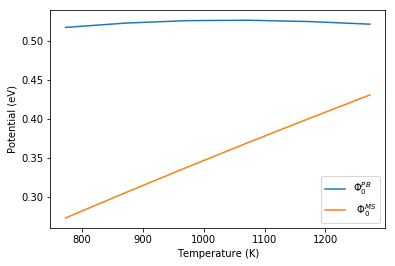

In [7]:
plt.plot( temp, space_charge_potential_list, label = '$\Phi_0^{PB}$' )
plt.plot( temp, MS_space_charge_potential_list, label = ' $\Phi_0^{MS}$' )
plt.xlabel( 'Temperature (K)' )
plt.ylabel( 'Potential (eV)' )
plt.legend()
plt.show()